In [1]:
# Step 2: Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [4]:
# Step 3: Load your EEG dataset
import os
import pandas as pd

# Define the directory path using raw string
data_dir = r'C:\Users\wesli\Downloads\Epileptic dataset\csv_files'

# Create an empty list to store the DataFrames
all_data = []

# Iterate over the files in the directory
for filename in os.listdir(data_dir):
    if filename.endswith(".csv"):
        # Create the full file path
        filepath = os.path.join(data_dir, filename)
        # Read the CSV file into a DataFrame
        try:
            df = pd.read_csv(filepath)
            # Add a 'Patient_ID' column based on the filename
            # Assuming filenames are like 'Patient_1_data.csv'
            patient_id = filename.split('_')[1]
            df['Patient_ID'] = patient_id
            # Append the DataFrame to the list
            all_data.append(df)
        except pd.errors.EmptyDataError:  # Handle empty files
            print(f"Skipping empty file: {filename}")
        except pd.errors.ParserError:  # Handle parsing errors
            print(f"Error parsing file: {filename}")
        except IndexError: # Handle cases where filename format is unexpected
            print(f"Unexpected filename format: {filename}, skipping Patient_ID assignment.")

# Concatenate all DataFrames into a single DataFrame (if needed)
if all_data:  # Check if any files were read successfully
    combined_df = pd.concat(all_data, ignore_index=True)
    # You can now use combined_df for further analysis
    print("Combined DataFrame shape:", combined_df.shape)
else:
    print("No CSV files found or processed successfully in the directory.")

Combined DataFrame shape: (9418240, 17)


In [8]:
# Step 4: Select only 5 patients and 3000 samples
unique_patients = combined_df['Patient_ID'].unique()
selected_patients = unique_patients[:5]  # First 5 patients
df_5 = combined_df[combined_df['Patient_ID'].isin(selected_patients)].copy()

# Select exactly 3000 samples randomly
df_5 = df_5.sample(n=3000, random_state=42)

print(f"Selected data shape: {df_5.shape}")

Selected data shape: (3000, 17)


In [9]:
# Handle missing values (if any)
missing = df_5.isnull().sum().sum()
print(f"Total missing values: {missing}")

# Optionally drop or fill
df_5.dropna(inplace=True)  # or df_2.fillna(method='ffill', inplace=True)


Total missing values: 0


In [10]:
# Step 5: Preprocess (for 2 patients with 3000 samples)
# Ensure df_2 contains only the selected 3000 samples from 2 patients
# If not already sampled:
df_3000 = df_5.sample(n=3000, random_state=42).reset_index(drop=True)

# Check if 'Label' column exists before dropping
if 'Label' in df_3000.columns:
    X = df_3000.drop(columns=['Patient_ID', 'Label'])  # EEG feature matrix
    y = df_3000['Label']  # Target labels
else:
    # Handle case where 'Label' column is not found
    print("Warning: 'Label' column not found. Assuming last column as target.")

    # Assuming the last column is the target and dropping 'Patient_ID'
    X = df_3000.drop(columns=['Patient_ID', df_3000.columns[-1]])
    y = df_3000[df_3000.columns[-1]]

# Normalize EEG features using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

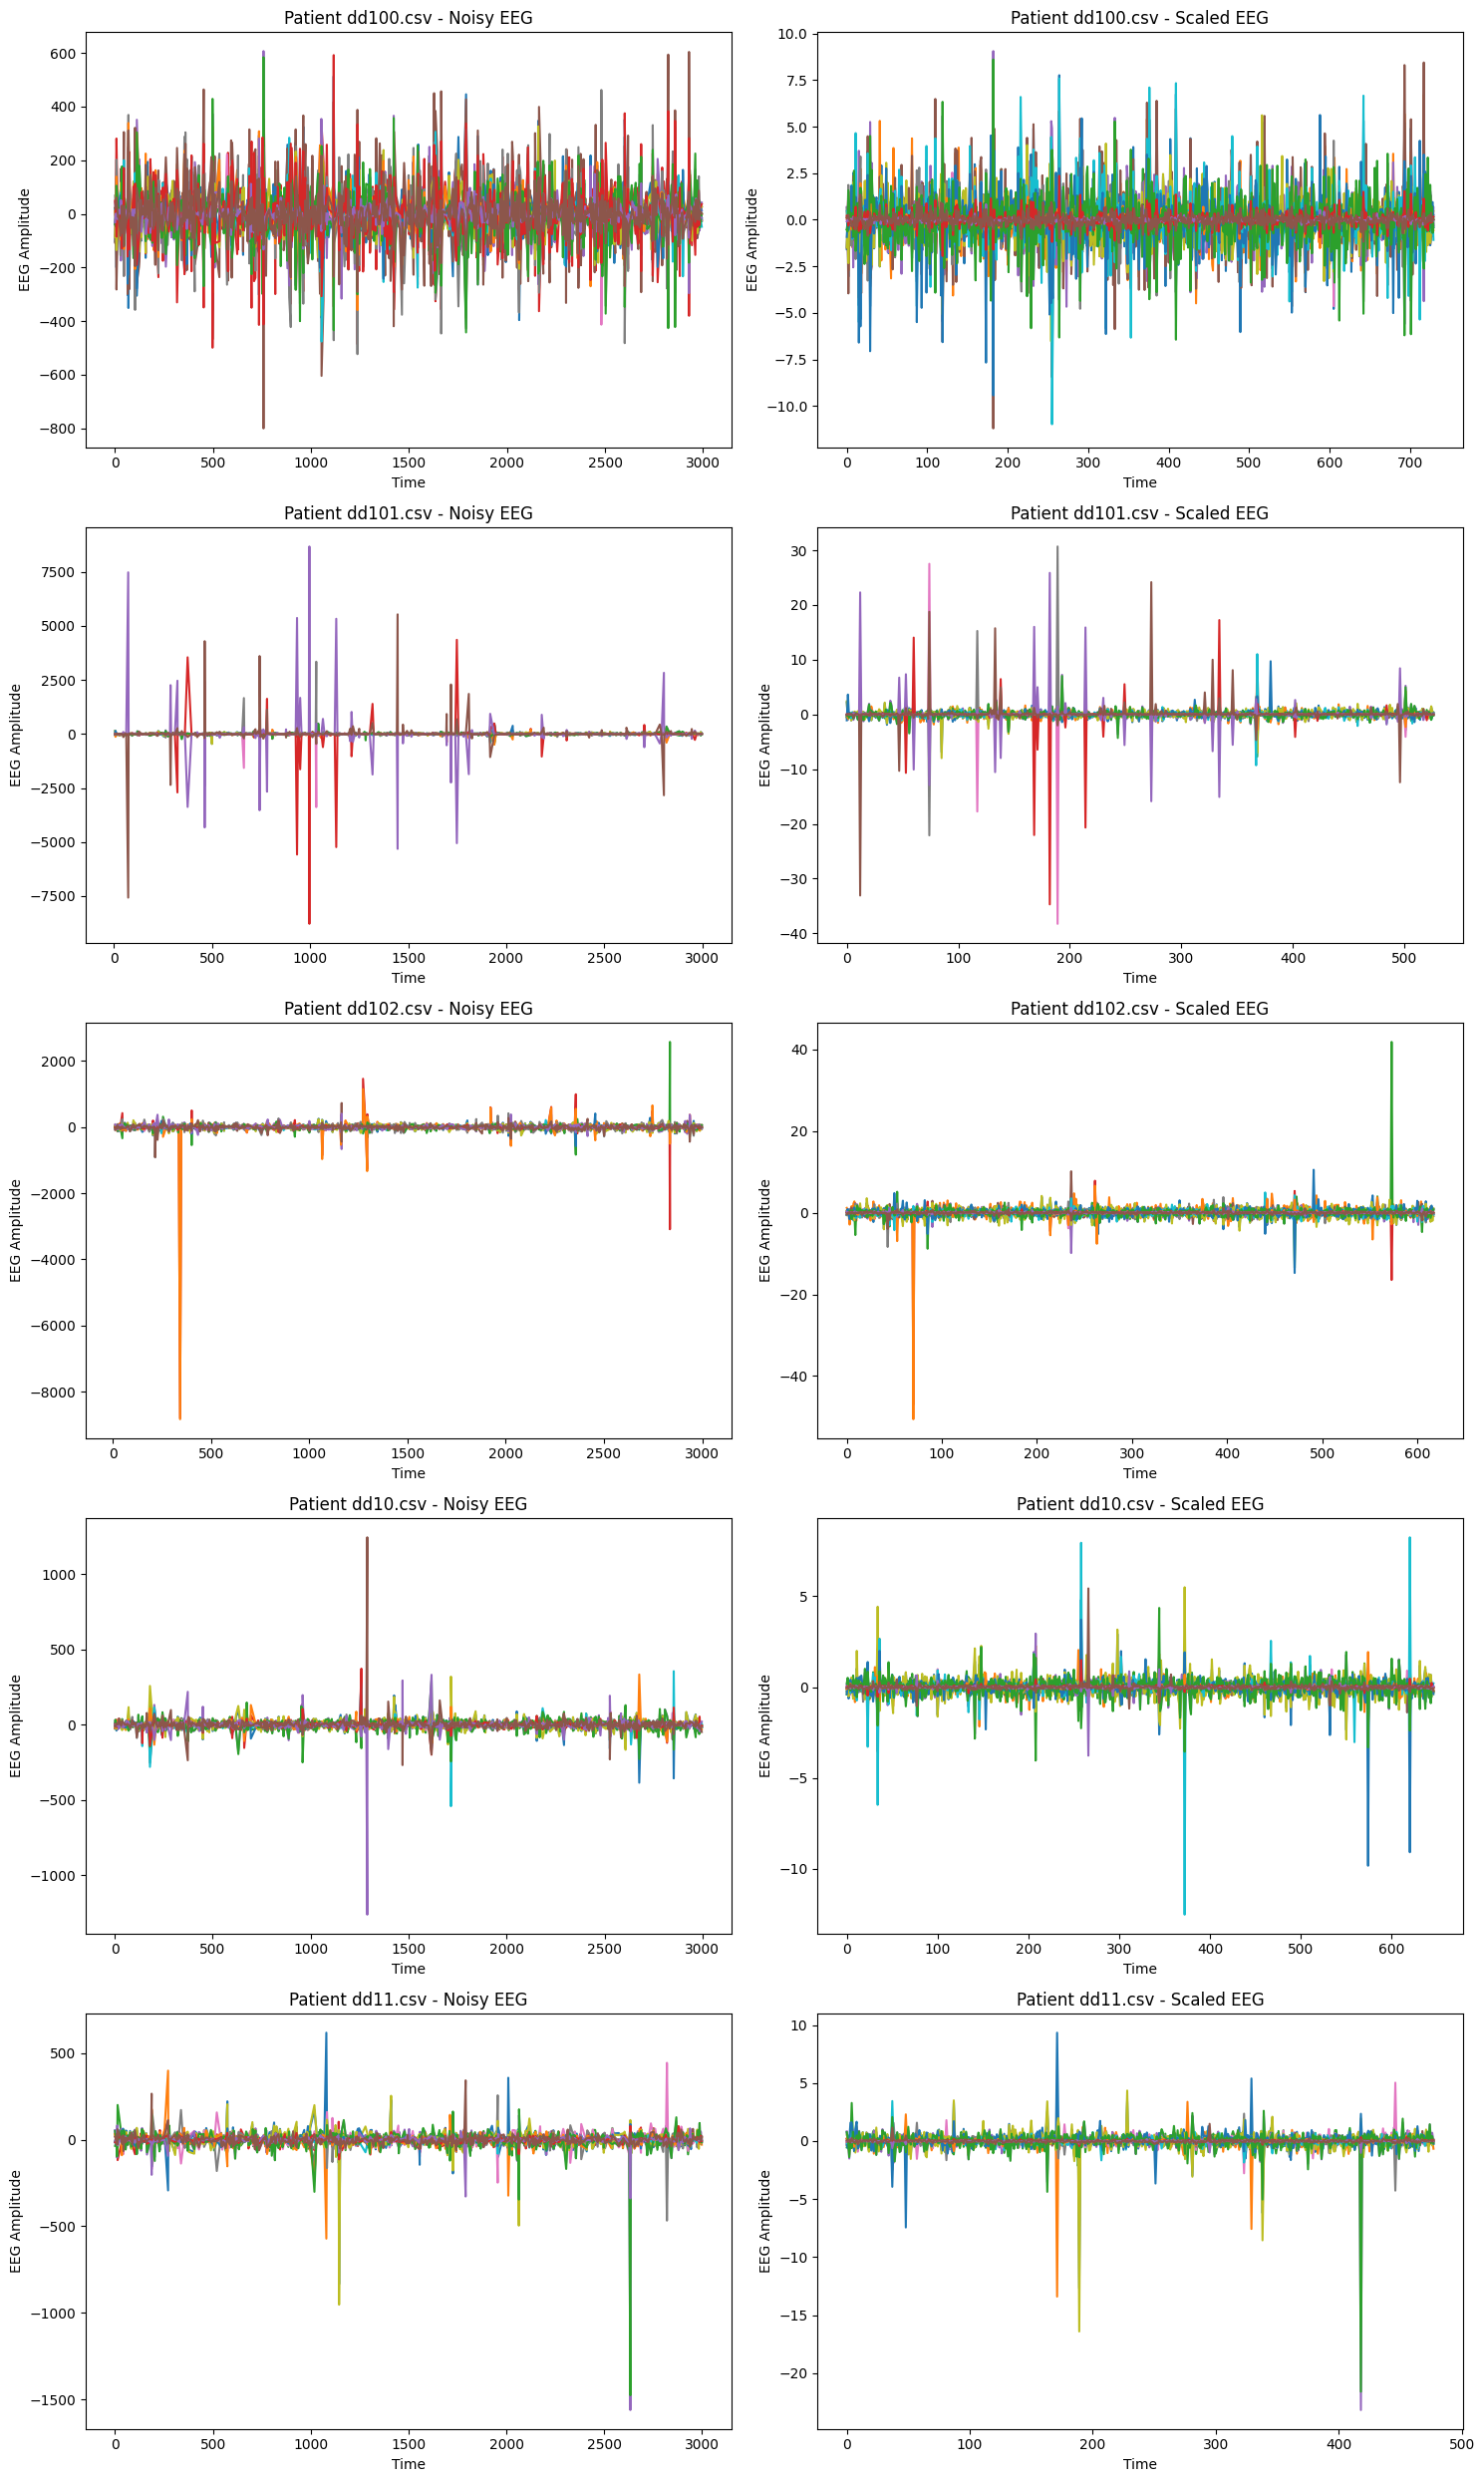

In [11]:
import matplotlib.pyplot as plt

num_patients = 5
fig, axes = plt.subplots(num_patients, 2, figsize=(15, 5 * num_patients))

for i in range(num_patients):
    patient_data = df_3000[df_3000['Patient_ID'] == selected_patients[i]]

    # Safe drop
    columns_to_drop = [col for col in ['Patient_ID', 'Label'] if col in patient_data.columns]
    patient_noisy_data = patient_data.drop(columns=columns_to_drop)

    patient_processed_data = scaler.transform(patient_noisy_data)

    # Plot raw data
    axes[i, 0].plot(patient_noisy_data.index, patient_noisy_data.values)
    axes[i, 0].set_title(f'Patient {selected_patients[i]} - Noisy EEG')

    # Plot scaled data
    axes[i, 1].plot(range(len(patient_processed_data)), patient_processed_data)
    axes[i, 1].set_title(f'Patient {selected_patients[i]} - Scaled EEG')

    for ax in axes[i]:
        ax.set_xlabel("Time")
        ax.set_ylabel("EEG Amplitude")

plt.tight_layout()
plt.show()


In [13]:
# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [14]:
# Step 7: Train the SVM model
svm = SVC(kernel='rbf', C=1.0, gamma='scale')
svm.fit(X_train, y_train)
# Step 8: Predict and evaluate
y_pred = svm.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("SVM Model Score:", svm.score(X_test, y_test))

Confusion Matrix:
 [[130   3   1   2   0]
 [ 35  87   4   8   3]
 [ 79  12  10   5   2]
 [ 30  13   3  66   3]
 [ 85   3   2   2  12]]

Classification Report:
               precision    recall  f1-score   support

    dd10.csv       0.36      0.96      0.53       136
   dd100.csv       0.74      0.64      0.68       137
   dd101.csv       0.50      0.09      0.16       108
   dd102.csv       0.80      0.57      0.67       115
    dd11.csv       0.60      0.12      0.19       104

    accuracy                           0.51       600
   macro avg       0.60      0.47      0.44       600
weighted avg       0.60      0.51      0.46       600

SVM Model Score: 0.5083333333333333


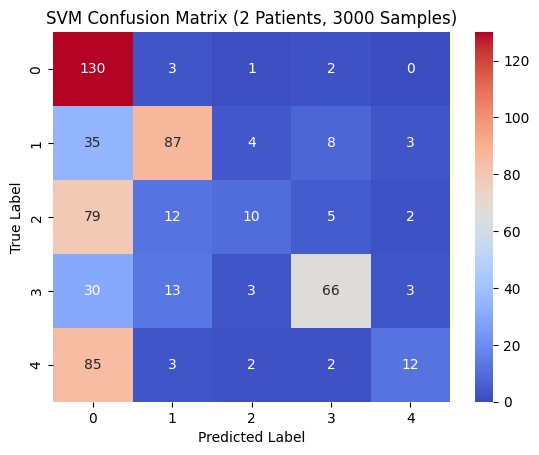

In [15]:
# Step 9: Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Confusion Matrix (2 Patients, 3000 Samples)')
plt.show()


In [16]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': [1, 0.1, 0.01, 0.001], # Kernel coefficient
    'kernel': ['rbf', 'linear'] # Kernel type
}

# Create a GridSearchCV object
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

# Fit the grid search to the data
grid.fit(X_train, y_train)

# Print the best parameters and score
print(f"Best parameters: {grid.best_params_}")
print(f"Best cross-validation score: {grid.best_score_}")

# Evaluate the best model on the test set
best_svm = grid.best_estimator_
y_pred = best_svm.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Best SVM Model Score:", best_svm.score(X_test, y_test))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.404 total time=   0.9s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.425 total time=   1.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.390 total time=   0.5s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.398 total time=   1.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.419 total time=   0.6s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.250 total time=   0.8s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.273 total time=   1.6s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.254 total time=   0.4s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.263 total time=   0.4s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.254 total time=   0.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.423 total time=   0.3s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

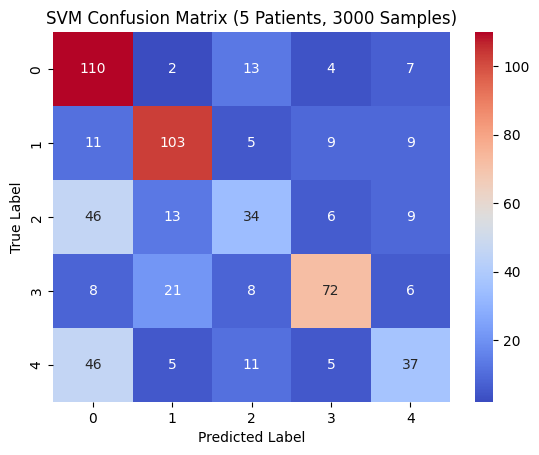

In [17]:
# Assuming 'y_test' and 'y_pred' are already defined from your SVM model
# Step 9: Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm') 
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Confusion Matrix (5 Patients, 3000 Samples)')
plt.show()


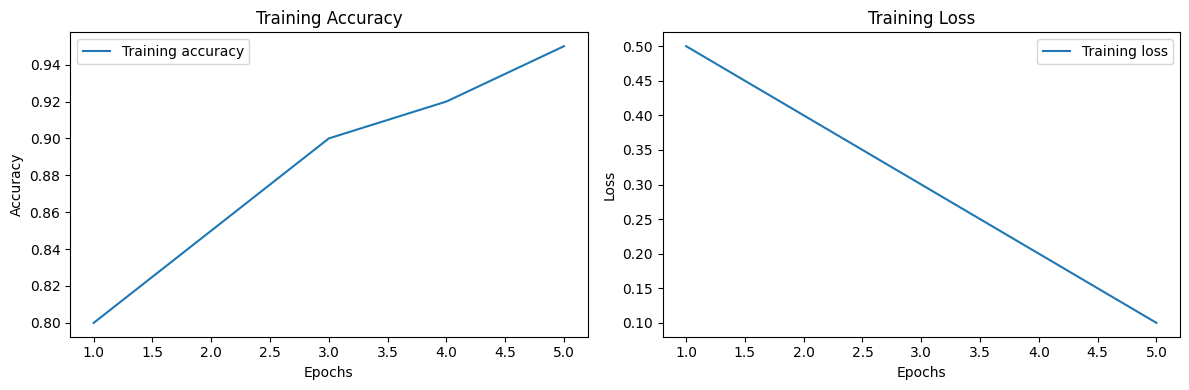

In [18]:
# Replace with your actual training history
history = {
    'accuracy': [0.8, 0.85, 0.9, 0.92, 0.95],  # Example accuracy values
    'loss': [0.5, 0.4, 0.3, 0.2, 0.1]  # Example loss values
}

epochs = range(1, len(history['accuracy']) + 1)

plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, history['accuracy'], label='Training accuracy')
# plt.plot(epochs, history['val_accuracy'], label='Validation accuracy')  # If available
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, history['loss'], label='Training loss')
# plt.plot(epochs, history['val_loss'], label='Validation loss')  # If available
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
